In [3]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import BertModel, BertTokenizer
# from transformers import AutoModel, AutoTokenizer

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Parameters
batch_size = 64
num_epochs = 5
num_samples = 10
learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

In [5]:
# load the "irony" dataset(name=irony)
cache_dir = "./data_cache_"
subset_name = "irony"

train_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_)} instances loaded")

val_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_)} instances loaded")

test_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_)} instances loaded")

num_classes_ = np.unique(train_dataset_['label']).size

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to ./data_cache_/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.
Training dataset with 2862 instances loaded


Validation dataset with 955 instances loaded


Test dataset with 784 instances loaded


In [6]:
# create Tokenizer object
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# create 'input_ids', 'token_type_ids', 'attention_mask' for train/val/test dataset
def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=100, truncation=True)
    return model_inputs

train_dataset_ = train_dataset_.map(tokenize_function, batched=True)
val_dataset_ = val_dataset_.map(tokenize_function, batched=True)
test_dataset_ = test_dataset_.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [7]:
# convert dataset to dataloader
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    # 'attention_mask' is also taken into consideration when constructing DataLoader(def forward())
    atten_tensor = torch.from_numpy(np.array(dataset['attention_mask']))
    
    tensor_dataset = TensorDataset(input_tensor, atten_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

# get all sentences ready for the model
train_loader = convert_to_data_loader(train_dataset_, num_classes_)
val_loader = convert_to_data_loader(val_dataset_, num_classes_)
test_loader = convert_to_data_loader(test_dataset_, num_classes_)

模型部分

In [8]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert, aleatoric_use, num_labels):
        super(BertClassifier, self).__init__()

        # use the pretrained bert model corresponding to the previous tokenizer
        self.aleatoric_use = aleatoric_use
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        # self.bert = BertModel.from_pretrained("robert-base")
        self.config = self.bert.config

        # specify the parameter for the classifier
        n_input = self.config.hidden_size
        n_hidden = 50
        p_ = 0.2

        # add dense layers to act as the classifier
        self.classifier = nn.Linear(n_input, n_hidden)

        self.predict = torch.nn.Linear(n_hidden, num_labels)   # predicted output
        self.get_var = torch.nn.Linear(n_hidden, num_labels)   # predicted variance

        # execute when freeze_bert=True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            for param in self.bert.parameters():
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        # get the outputs of the roberta model
        bert_outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask)

        # extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_outputs = bert_outputs[0][:,0,:]

        # Feed input to classifier to compute results(one number for each class)
        x = last_hidden_state_outputs  # 64*768
        x = self.classifier(x)  # 64*50
        x = F.relu(x)  # 64*50
        x = F.dropout(x, p=0.2)  # 64*50
        
        logits = self.predict(x)  # logits layer 64*2
        if self.aleatoric_use:  # consider aleatoric uncertainty --> two sets of output
          sigma = self.get_var(x)  # uncertainty layer 64*2
          return logits, sigma
        else:
          return logits

In [9]:
# model epistemic uncertainty
model_non = BertClassifier(freeze_bert=True, aleatoric_use=False, num_labels=num_classes_)
model_non

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [10]:
def train_non(num_epochs, model, train_dataloader, dev_dataloader):

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    # Store the data for plotting
    X = []
    train_losses_set = []
    train_accuracy_set = []
    dev_losses_set = []
    dev_accuracy_set = []
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        # batch_atten(atten_mask) is also used to compute the model output
        for i, (batch_input_ids, batch_atten, batch_labels) in enumerate(train_dataloader):

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            output = model(batch_input_ids, batch_atten)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)
            print("my batch loss:{}".format(batch_loss))

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        X.append(e+1)
        train_losses_set.append(np.mean(train_losses))
        train_accuracy_set.append(train_accuracy)

        model.eval()  # Switch model to evaluation mode
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_atten, dev_labels in dev_dataloader:

            # Use the model to performance forward inference on the development data
            dev_output = model(dev_input_ids,dev_atten)
            
            # Compute the loss for the development data
            dev_loss = loss_fn(dev_output, dev_labels)

            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())

            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
        
        dev_losses_set.append(np.mean(dev_losses))
        dev_accuracy_set.append(dev_accuracy)
    
    # Plotting to show the accuracy and loss
    plt.figure()
    plt.plot(X,train_accuracy_set,'ob--',label='Train Accuracy')
    plt.plot(X,dev_accuracy_set,'or--',label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy(%)')
    
    plt.figure()
    plt.plot(X,train_losses_set,'ob--',label='Train Loss')
    plt.plot(X,dev_losses_set,'or--',label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    
    return model

my batch loss:0.7247692942619324
my batch loss:0.7015418410301208
my batch loss:0.6958779692649841
my batch loss:0.7016679644584656
my batch loss:0.7005321383476257
my batch loss:0.6827318072319031
my batch loss:0.6822390556335449
my batch loss:0.6801052093505859
my batch loss:0.6780811548233032
my batch loss:0.7036497592926025
my batch loss:0.7177002429962158
my batch loss:0.6890429258346558
my batch loss:0.7153587937355042
my batch loss:0.6843470335006714
my batch loss:0.6812563538551331
my batch loss:0.6863844394683838
my batch loss:0.6890351176261902
my batch loss:0.6759907603263855
my batch loss:0.678257405757904
my batch loss:0.6824473738670349
my batch loss:0.6777647137641907
my batch loss:0.6738585829734802
my batch loss:0.7016118168830872
my batch loss:0.6554211378097534
my batch loss:0.6787512302398682
my batch loss:0.680314302444458
my batch loss:0.6877387762069702
my batch loss:0.6539056897163391
my batch loss:0.6531363725662231
my batch loss:0.6616506576538086
my batch los

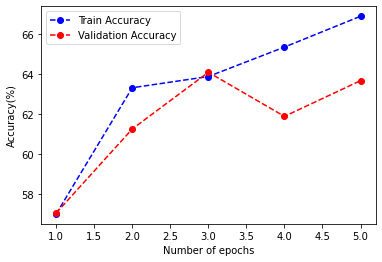

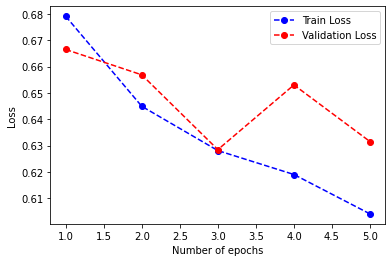

In [11]:
# model epistemic uncertainty
trained_model = train_non(num_epochs=num_epochs, model=model_non, train_dataloader=train_loader, dev_dataloader=val_loader)

predict

In [12]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, atten, labels in test_loader:
        test_mu = trained_model(inputs, atten)
        # take the label with biggest output as the predicted label
        predicted_labels = test_mu.argmax(1)

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

In [13]:
gold_labs, pred_labs = predict_nn(trained_model, test_loader)

# classification report
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = ['irony', 'not irony']
print("The classification report is:")
print(classification_report(gold_labs, pred_labs,target_names=target_names))

# confusion matrix
cm = confusion_matrix(gold_labs, pred_labs)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
print("The confusion matrix is:")
print(df_cm)

The classification report is:
              precision    recall  f1-score   support

       irony       0.79      0.52      0.63       473
   not irony       0.52      0.79      0.63       311

    accuracy                           0.63       784
   macro avg       0.66      0.66      0.63       784
weighted avg       0.69      0.63      0.63       784

The confusion matrix is:
           irony  not irony
irony        246        227
not irony     64        247


In [14]:
from sklearn.metrics import f1_score
f1_score(gold_labs, pred_labs, average='macro')

0.6288259267393903

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_labs, pred_labs)

0.6288265306122449